# Read Data

In [1]:
import numpy as np  
dataset = 20
  
with np.load("./data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("./data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load("./data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("./data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images

In [2]:
# encoder
print("encoder data-----------------:")
print("encoder_counts", encoder_counts.shape)
print("encoder_stamps", encoder_stamps.shape)
# lidar
print("lidar data-------------------:")
print("lidar_angle_min", lidar_angle_min)
print("lidar_angle_max", lidar_angle_max)
print("lidar_angle_increment", lidar_angle_increment)
print("lidar_range_min", lidar_range_min)
print("lidar_range_max", lidar_range_max)
print("lidar_ranges", lidar_ranges.shape)
print("lidar_stamps", lidar_stamps.shape)
# imu
print("imu data---------------------:")
print("imu_angular_velocity", imu_angular_velocity.shape)
print("imu_linear_acceleration", imu_linear_acceleration.shape)
print("imu_stamps", imu_stamps.shape)
# kinect
print("kinect data------------------:")
print("disp_stamps", disp_stamps.shape)
print("rgb_stamps", rgb_stamps.shape)

encoder data-----------------:
encoder_counts (4, 4956)
encoder_stamps (4956,)
lidar data-------------------:
lidar_angle_min -2.356194490192345
lidar_angle_max 2.356194490192345
lidar_angle_increment [[0.00436332]]
lidar_range_min 0.1
lidar_range_max 30
lidar_ranges (1081, 4962)
lidar_stamps (4962,)
imu data---------------------:
imu_angular_velocity (3, 12187)
imu_linear_acceleration (3, 12187)
imu_stamps (12187,)
kinect data------------------:
disp_stamps (2407,)
rgb_stamps (2289,)


# Time Synchronization

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def integrate_imu_yaw_rate(imu_stamps, imu_angular_velocity, start_time, end_time):
    indices = np.where((imu_stamps >= start_time) & (imu_stamps <= end_time))
    selected_yaw_rates = imu_angular_velocity[indices]
    if len(selected_yaw_rates) == 0:
        return 0.0
    else:
        yaw_change = np.mean(selected_yaw_rates) * (end_time - start_time)
        return yaw_change

aligned_encoder = [np.array([0, 0, 0, 0], dtype=np.int16)]
aligned_imu_yaw = [0.0]

for i in range(len(lidar_stamps)):
    if i > 0:
        nearest_encoder_idx = find_nearest(encoder_stamps, lidar_stamps[i])
        aligned_encoder.append(encoder_counts[:, nearest_encoder_idx])
    if i == 0:
        continue
    imu_yaw_change = integrate_imu_yaw_rate(imu_stamps, imu_angular_velocity[2], lidar_stamps[i-1], lidar_stamps[i])
    aligned_imu_yaw.append(imu_yaw_change)


# Encoder Preprocsess

In [4]:
pose = [0, 0, 0]
odom_pose_list = [pose.copy()]
for i in range(len(lidar_stamps)):
    if i == 0:
        continue
    else:
        d_r = (aligned_encoder[i][0] + aligned_encoder[i][2]) / 2 * 0.0022
        d_l = (aligned_encoder[i][1] + aligned_encoder[i][3]) / 2 * 0.0022
    pose[0] += (d_l + d_r) / 2 * np.cos(pose[2])
    pose[1] += (d_l + d_r) / 2 * np.sin(pose[2])
    pose[2] += aligned_imu_yaw[i]
    # restrict the angle to [-pi, pi]
    if pose[2] > np.pi:
        pose[2] -= 2 * np.pi
    elif pose[2] < -np.pi:
        pose[2] += 2 * np.pi
    
    odom_pose_list.append(pose.copy())

In [5]:
# from (x, y, theta) to transformation matrix
def pose2trans(pose):
    x, y, theta = pose
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

odom_poses = []
for pose in odom_pose_list:
    odom_poses.append(pose2trans(pose))
odom_poses = np.array(odom_poses)

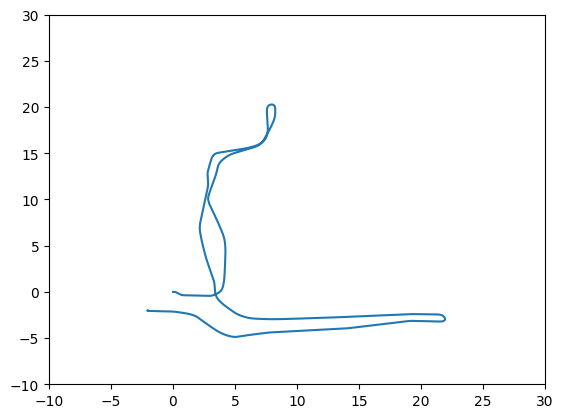

In [6]:
# plot the trajectory
import matplotlib.pyplot as plt
plt.plot(odom_poses[:, 0, 2], odom_poses[:, 1, 2])
plt.xlim(-10, 30)
plt.ylim(-10, 30)
plt.show()

# Mapping with Odom

In [7]:
# convert lidar measurements to points
def lidar_to_points(lidar_ranges, angle_min, angle_increment, min_range=0.1, max_range=30.0):
    angles = np.arange(angle_min, angle_min + len(lidar_ranges) * angle_increment, angle_increment)
    points = np.zeros((len(lidar_ranges), 2))
    points[:, 0] = lidar_ranges * np.cos(angles)
    points[:, 1] = lidar_ranges * np.sin(angles)
    # remove points that are too close or too far
    mask = (lidar_ranges >= min_range) & (lidar_ranges <= max_range)
    return points[mask]

/tmp/ipykernel_171729/2822300035.py:50: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


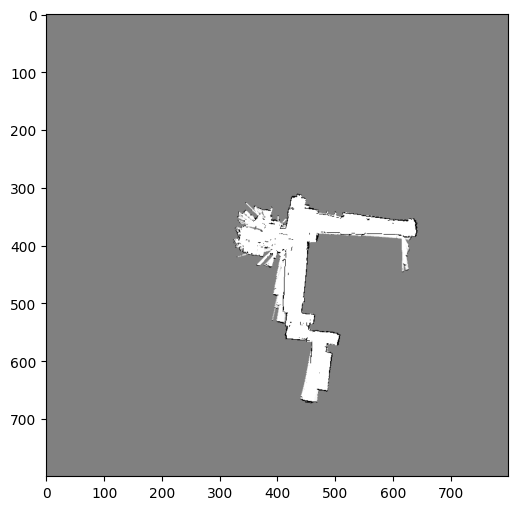

In [8]:
width = 800
resolution = 0.1 
grid_map = np.zeros((width, width), dtype=np.float32)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free

# transform result_poses to transformation matrix
odom_poses = np.array([pose2trans(pose) for pose in odom_pose_list])

for i in range(1, len(lidar_stamps), 20):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = odom_poses[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)
        
prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(6, 6))
plt.imshow(prob_map, cmap='gray')
plt.show()

# ICP without initial guess

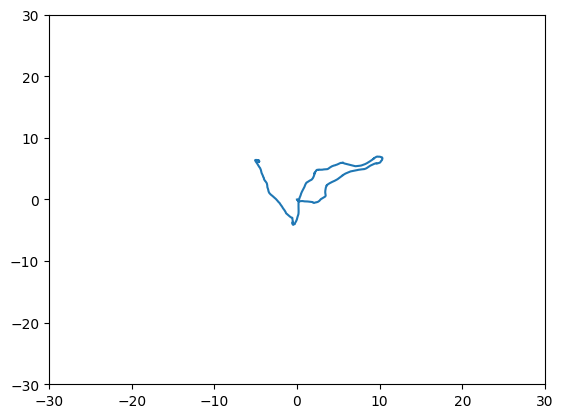

In [9]:
import ICP
# ICP without initial guess
T = np.eye(3)
pose_list = [T]
for i in range(1, len(lidar_stamps)):
    lidar1 = lidar_to_points(lidar_ranges[:,i-1], lidar_angle_min, lidar_angle_increment)
    lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    # make sure the point clouds are of the same size
    min_size = min(lidar1.shape[0], lidar2.shape[0])
    lidar1 = lidar1[:min_size]
    lidar2 = lidar2[:min_size]
    # ICP
    T_, distances, _ = ICP.icp(lidar2, lidar1, init_pose=np.eye(3), max_iterations=200)
    T = np.dot(T, T_)
    pose_list.append(T)

# plot the trajectory
pose_list = np.array(pose_list)
plt.plot(pose_list[:, 0, 2], pose_list[:, 1, 2])
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

/tmp/ipykernel_171729/896459745.py:47: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


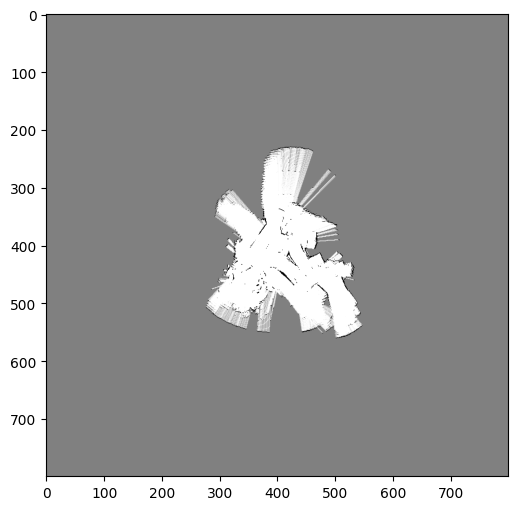

In [10]:
width = 800
resolution = 0.1 
grid_map = np.zeros((width, width), dtype=np.float32)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free

for i in range(1, len(lidar_stamps), 20):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = pose_list[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)
        
prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(6, 6))
plt.imshow(prob_map, cmap='gray')
plt.show()

# ICP with initial guess

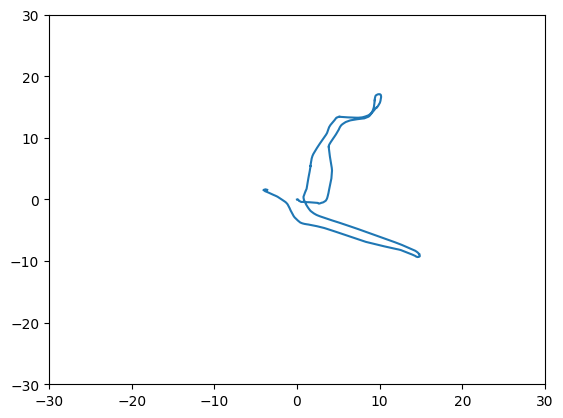

In [11]:
# ICP with initial guess
T = np.eye(3)
pose_list = [T]
for i in range(1, len(lidar_stamps)):
    lidar1 = lidar_to_points(lidar_ranges[:,i-1], lidar_angle_min, lidar_angle_increment)
    lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    # make sure the point clouds are of the same size
    min_size = min(lidar1.shape[0], lidar2.shape[0])
    lidar1 = lidar1[:min_size]
    lidar2 = lidar2[:min_size]
    # initial guess
    initial_guess = np.linalg.inv(odom_poses[i-1]).dot(odom_poses[i])
    # ICP
    T_, distances, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
    T = np.dot(T, T_)
    pose_list.append(T)

# plot the trajectory
pose_list = np.array(pose_list)
plt.plot(pose_list[:, 0, 2], pose_list[:, 1, 2])
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

/tmp/ipykernel_171729/896459745.py:47: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


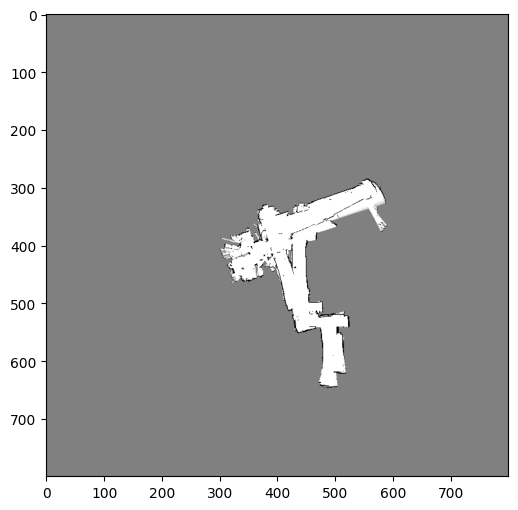

In [12]:
width = 800
resolution = 0.1 
grid_map = np.zeros((width, width), dtype=np.float32)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free

for i in range(1, len(lidar_stamps), 20):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = pose_list[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)
        
prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(6, 6))
plt.imshow(prob_map, cmap='gray')
plt.show()

# ICP + fixed loop closure

optimized


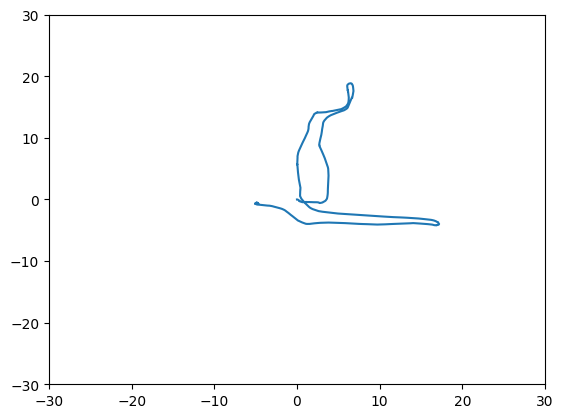

In [13]:
# ICP with fixed loop closure
import gtsam

fixed_closure_interval = 20
optimization_interval = 1000

T = np.eye(3)
pose_list = [T]
graph = gtsam.NonlinearFactorGraph()

# add prior factor
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), prior_noise))

def find_nearest_pose(pose_list, pose):
    distances = np.linalg.norm(pose_list - pose, axis=(1, 2))
    nearest_idx = np.argsort(distances)
    return nearest_idx

for i in range(1, len(lidar_ranges[0])):
    lidar1 = lidar_to_points(lidar_ranges[:,i-1], lidar_angle_min, lidar_angle_increment)
    lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    min_size = min(lidar1.shape[0], lidar2.shape[0])
    lidar1, lidar2 = lidar1[:min_size], lidar2[:min_size]
    initial_guess = np.linalg.inv(odom_poses[i-1]).dot(odom_poses[i])
    T_, distances, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
    T = np.dot(T, T_)
    # add lidar odometry factor
    odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
    relative_pose = T_
    graph.add(gtsam.BetweenFactorPose2(i, i+1, gtsam.Pose2(relative_pose[0, 2], relative_pose[1, 2], np.arctan2(relative_pose[1, 0], relative_pose[0, 0])), odometry_noise))
    pose_list.append(T)

    # add fixed loop closure factor
    if i % fixed_closure_interval == 0 and i > fixed_closure_interval:
        lidar1 = lidar_to_points(lidar_ranges[:,i-fixed_closure_interval], lidar_angle_min, lidar_angle_increment)
        lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
        min_size = min(lidar1.shape[0], lidar2.shape[0])
        lidar1, lidar2 = lidar1[:min_size], lidar2[:min_size]
        initial_guess = np.linalg.inv(odom_poses[i-fixed_closure_interval]).dot(odom_poses[i])
        T_, dis, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
        # check if the loop closure is valid
        if np.mean(dis) < 0.10:
            loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
            fixed_loop_closure_factor = gtsam.BetweenFactorPose2(i-fixed_closure_interval, i, gtsam.Pose2(T_[0, 2], T_[1, 2], np.arctan2(T_[1, 0], T_[0, 0])), loop_closure_noise)
            graph.add(fixed_loop_closure_factor)

initial_guess = gtsam.Values()
for i, T in enumerate(odom_poses[:i+1], 1):
    initial_guess.insert(i, gtsam.Pose2(T[0, 2], T[1, 2], np.arctan2(T[1, 0], T[0, 0])))
# optimize
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_guess)
result = optimizer.optimize()
print('optimized')

result_poses = []
for i in range(1, len(pose_list)+1):
    result_poses.append([result.atPose2(i).x(), result.atPose2(i).y(), result.atPose2(i).theta()])
result_poses = np.array(result_poses)
plt.plot(result_poses[:, 0], result_poses[:, 1])
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.show()

/tmp/ipykernel_171729/2340982406.py:51: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


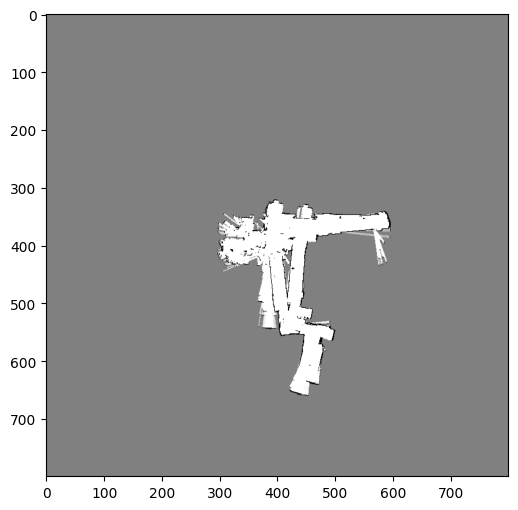

In [14]:
width = 800
resolution = 0.1 
grid_map = np.zeros((width, width), dtype=np.float32)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free


# transform result_poses to transformation matrix
result_poses = np.array([pose2trans(pose) for pose in result_poses])

for i in range(1, len(lidar_stamps), 20):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = result_poses[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)
        
prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(6, 6))
plt.imshow(prob_map, cmap='gray')
plt.show()

# ICP + global and fixed loop closure

iter: 961
optimized
iter: 1961
optimized
iter: 2961
optimized
iter: 3961
optimized
global loop closure between 254 and 4700
global loop closure between 254 and 4800
global loop closure between 254 and 4900
iter: 4961
optimized


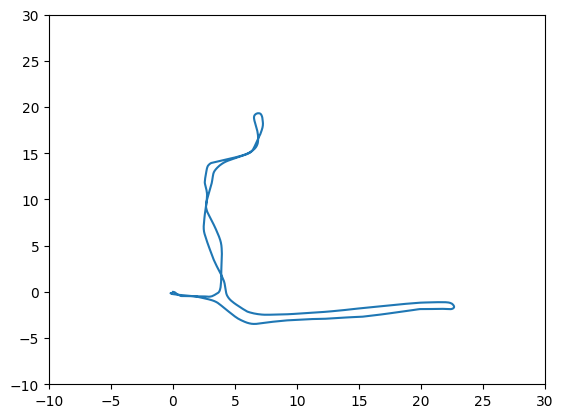

In [15]:
# ICP with global and fixed loop closure
import gtsam

fixed_closure_interval = 30
global_closure_interval = 100
global_closure_min_teps = 800
optimization_interval = 1000

T = np.eye(3)
pose_list = [T]
graph = gtsam.NonlinearFactorGraph()

# add prior factor
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), prior_noise))

def find_nearest_pose(pose_list, pose):
    distances = np.linalg.norm(pose_list - pose, axis=(1, 2))
    nearest_idx = np.argsort(distances)
    return nearest_idx

for i in range(1, len(lidar_ranges[0])):
    lidar1 = lidar_to_points(lidar_ranges[:,i-1], lidar_angle_min, lidar_angle_increment)
    lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    min_size = min(lidar1.shape[0], lidar2.shape[0])
    lidar1, lidar2 = lidar1[:min_size], lidar2[:min_size]
    initial_guess = np.linalg.inv(odom_poses[i-1]).dot(odom_poses[i])
    T_, distances, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
    if np.mean(distances) < 0.10:
        T = np.dot(T, T_)
        # add lidar odometry factor
        odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
        relative_pose = T_
        graph.add(gtsam.BetweenFactorPose2(i, i+1, gtsam.Pose2(relative_pose[0, 2], relative_pose[1, 2], np.arctan2(relative_pose[1, 0], relative_pose[0, 0])), odometry_noise))
    else:
        T = np.dot(T, initial_guess)
    pose_list.append(T)
    
    # add odometry factor
    odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.05, 0.05, 0.05]))
    relative_pose = initial_guess
    graph.add(gtsam.BetweenFactorPose2(i, i+1, gtsam.Pose2(relative_pose[0, 2], relative_pose[1, 2], np.arctan2(relative_pose[1, 0], relative_pose[0, 0])), odometry_noise))

    # add fixed loop closure factor
    if i % fixed_closure_interval == 0 and i > fixed_closure_interval:
        lidar1 = lidar_to_points(lidar_ranges[:,i-fixed_closure_interval], lidar_angle_min, lidar_angle_increment)
        lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
        min_size = min(lidar1.shape[0], lidar2.shape[0])
        lidar1, lidar2 = lidar1[:min_size], lidar2[:min_size]
        initial_guess = np.linalg.inv(odom_poses[i-fixed_closure_interval]).dot(odom_poses[i])
        T_, dis, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
        # check if the loop closure is valid
        if np.mean(dis) < 0.10:
            loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
            fixed_loop_closure_factor = gtsam.BetweenFactorPose2(i-fixed_closure_interval, i, gtsam.Pose2(T_[0, 2], T_[1, 2], np.arctan2(T_[1, 0], T_[0, 0])), loop_closure_noise)
            graph.add(fixed_loop_closure_factor)

    # add global loop closure factor
    if i > global_closure_min_teps and i % global_closure_interval == 0:
        nearest_idx = find_nearest_pose(odom_poses[:i - global_closure_min_teps], odom_poses[i])[0]
        # icp
        lidar1 = lidar_to_points(lidar_ranges[:,nearest_idx], lidar_angle_min, lidar_angle_increment)
        lidar2 = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
        min_size = min(lidar1.shape[0], lidar2.shape[0])
        lidar1, lidar2 = lidar1[:min_size], lidar2[:min_size]
        initial_guess = np.linalg.inv(odom_poses[nearest_idx]).dot(odom_poses[i])
        T_, dis, _ = ICP.icp(lidar2, lidar1, init_pose=initial_guess, max_iterations=20)
        # check if the loop closure is valid
        if np.mean(dis) < 0.20:
            print('global loop closure between %d and %d'%(nearest_idx, i))
            global_loop_closure_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.1, 0.1, 0.1]))
            global_loop_closure_factor = gtsam.BetweenFactorPose2(nearest_idx+1, i, gtsam.Pose2(T_[0, 2], T_[1, 2], np.arctan2(T_[1, 0], T_[0, 0])), global_loop_closure_noise)
            graph.add(global_loop_closure_factor)

    if i % optimization_interval == len(lidar_ranges[0]) % optimization_interval -1:
        print('iter:', i)
        # initial guess
        initial_guess = gtsam.Values()
        for i, T in enumerate(odom_poses[:i+1], 1):
            initial_guess.insert(i, gtsam.Pose2(T[0, 2], T[1, 2], np.arctan2(T[1, 0], T[0, 0])))
        # optimize
        optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_guess)
        result = optimizer.optimize()
        print('optimized')
        # result_poses = []
        # for i in range(1, len(pose_list)+1):
        #     result_poses.append([result.atPose2(i).x(), result.atPose2(i).y(), result.atPose2(i).theta()])
        # result_poses = np.array(result_poses)
        # plt.plot(result_poses[:, 0], result_poses[:, 1])
        # plt.xlim(-30, 30)
        # plt.ylim(-30, 30)
        # plt.show()

# final optimization
initial_guess = gtsam.Values()
for i, T in enumerate(odom_poses, 1):
    initial_guess.insert(i, gtsam.Pose2(T[0, 2], T[1, 2], np.arctan2(T[1, 0], T[0, 0])))
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_guess)
result = optimizer.optimize()
result_poses = []
for i in range(1, len(pose_list)+1):
    result_poses.append([result.atPose2(i).x(), result.atPose2(i).y(), result.atPose2(i).theta()])
result_poses = np.array(result_poses)
plt.plot(result_poses[:, 0], result_poses[:, 1])
plt.xlim(-10, 30)
plt.ylim(-10, 30)
plt.show()

/tmp/ipykernel_171729/1140186518.py:50: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


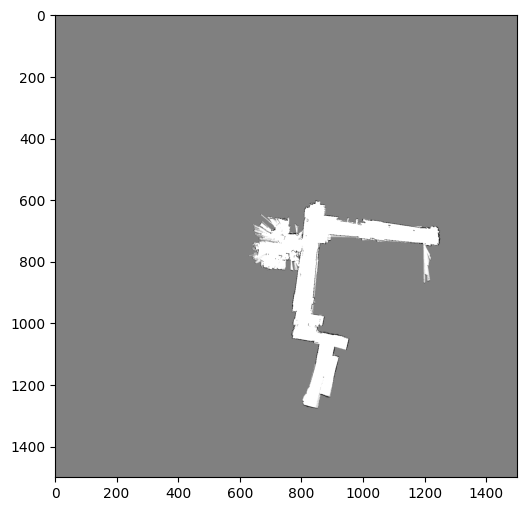

In [16]:
width = 1500
resolution = 0.05 
grid_map = np.zeros((width, width), dtype=np.float32)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free

# transform result_poses to transformation matrix
result_poses = np.array([pose2trans(pose) for pose in result_poses])

for i in range(1, len(lidar_stamps), 20):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = result_poses[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)
        
prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(6, 6))
plt.imshow(prob_map, cmap='gray')
plt.show()

# RGBD Texture

In [17]:
import cv2
import transforms3d as t3d
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


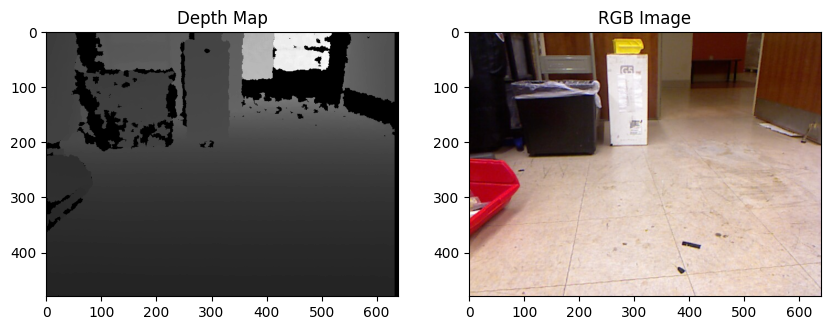

In [18]:
disparity_folder = f'./dataRGBD/Disparity{dataset}/'
rgb_folder = f'./dataRGBD/RGB{dataset}/'

for i in range(1, 2):
    disparity_filename = f'{disparity_folder}disparity{dataset}_{i}.png'
    rgb_filename = f'{rgb_folder}rgb{dataset}_{i}.png'

    disparity_img = cv2.imread(disparity_filename, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.imread(rgb_filename)
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

    dd = (-0.00304 * disparity_img) + 3.31

    depth = 1.03 / dd

    # visualization
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(depth, cmap='gray')
    plt.title('Depth Map')
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_img)
    plt.title('RGB Image')
    plt.show()

    height, width = disparity_img.shape
    i_coords, j_coords = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # calculate the coordinates in the rgb image
    rgbi = (526.37 * i_coords + 19276 - 7877.07 * dd) / 585.051
    rgbj = (526.37 * j_coords + 16662) / 585.051

    rgb_coordinates = np.stack((rgbi, rgbj), axis=-1)
    color = rgb_img.reshape(-1, 3)

    # transform the pixels to pointcloud
    K = np.array([[585.05, 0, 242.941],
                [0, 585.05, 315.84],
                [0, 0, 1]])
    K_inv = np.linalg.inv(K)
    camera_position = np.array([0.18, 0.005, 0.36]) 
    camera_orientation = np.array([0, 0.36, 0.021]) 
    R = t3d.euler.euler2mat(camera_orientation[0], camera_orientation[1], camera_orientation[2], 'sxyz')
    T_camera_to_robot = np.zeros((4, 4))
    T_camera_to_robot[:3, :3] = R
    T_camera_to_robot[:3, 3] = camera_position
    T_camera_to_robot[3, 3] = 1
    T_finetuned = np.array([[0, 0, 1, 0],
                            [0, -1, 0, 0],
                            [-1, 0, 0, 0],
                            [0, 0, 0, 1]])

    j, i = np.meshgrid(range(rgb_coordinates.shape[1]), range(rgb_coordinates.shape[0]))
    i, j = i.flatten(), j.flatten()

    homogeneous_coords = np.vstack((i, j, np.ones_like(i)))

    world_coords = np.dot(K_inv, homogeneous_coords) * depth.flatten()

    world_coords_homogeneous = np.vstack((world_coords, np.ones((1, world_coords.shape[1]))))

    point_robot = np.dot(T_camera_to_robot, world_coords_homogeneous)

    point_robot_finetuned = np.dot(T_finetuned, point_robot)

    point_cloud = point_robot_finetuned[:3, :].T
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(color / 255.0)
    o3d.visualization.draw_geometries([pcd])

    # get the ground(z < -0.6 and distance < 5)
    mask = (point_cloud[:, 2] < -0.6) & (np.linalg.norm(point_cloud[:, :2], axis=1) < 5)
    point_cloud = point_cloud[mask]
    color = color[mask]

    pcd_ground = o3d.geometry.PointCloud()
    pcd_ground.points = o3d.utility.Vector3dVector(point_cloud)
    pcd_ground.colors = o3d.utility.Vector3dVector(color / 255.0)
    o3d.visualization.draw_geometries([pcd_ground])

In [19]:
def get_rgbd_pcd(disparity_filename, rgb_filename):
    disparity_img = cv2.imread(disparity_filename, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.imread(rgb_filename)
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

    dd = (-0.00304 * disparity_img) + 3.31

    depth = 1.03 / dd
    
    height, width = disparity_img.shape
    i_coords, j_coords = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

    # calculate the coordinates in the rgb image
    rgbi = (526.37 * i_coords + 19276 - 7877.07 * dd) / 585.051
    rgbj = (526.37 * j_coords + 16662) / 585.051

    rgb_coordinates = np.stack((rgbi, rgbj), axis=-1)
    color = rgb_img.reshape(-1, 3)

    # transform the pixels to pointcloud
    K = np.array([[585.05, 0, 242.941],
                [0, 585.05, 315.84],
                [0, 0, 1]])
    K_inv = np.linalg.inv(K)
    camera_position = np.array([0.18, 0.005, 0.36]) 
    camera_orientation = np.array([0, 0.36, 0.021]) 
    R = t3d.euler.euler2mat(camera_orientation[0], camera_orientation[1], camera_orientation[2], 'sxyz')
    T_camera_to_robot = np.zeros((4, 4))
    T_camera_to_robot[:3, :3] = R
    T_camera_to_robot[:3, 3] = camera_position
    T_camera_to_robot[3, 3] = 1
    T_finetuned = np.array([[0, 0, 1, 0],
                            [0, -1, 0, 0],
                            [-1, 0, 0, 0],
                            [0, 0, 0, 1]])

    j, i = np.meshgrid(range(rgb_coordinates.shape[1]), range(rgb_coordinates.shape[0]))
    i, j = i.flatten(), j.flatten()

    homogeneous_coords = np.vstack((i, j, np.ones_like(i)))

    world_coords = np.dot(K_inv, homogeneous_coords) * depth.flatten()

    world_coords_homogeneous = np.vstack((world_coords, np.ones((1, world_coords.shape[1]))))

    point_robot = np.dot(T_camera_to_robot, world_coords_homogeneous)

    point_robot_finetuned = np.dot(T_finetuned, point_robot)

    point_cloud = point_robot_finetuned[:3, :].T
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(color / 255.0)

    # get the ground(z < -0.6 and distance < 5)
    mask = (point_cloud[:, 2] < -0.6) & (np.linalg.norm(point_cloud[:, :2], axis=1) < 5)
    point_cloud = point_cloud[mask]
    color = color[mask]

    pcd_ground = o3d.geometry.PointCloud()
    pcd_ground.points = o3d.utility.Vector3dVector(point_cloud)
    pcd_ground.colors = o3d.utility.Vector3dVector(color / 255.0)
    return pcd, pcd_ground

# align the stamps of the lidar and the kinect
print('aligning the timestamps and extracting the ground pointcloud')
print('about 3 minutes-----------------')
aligned_ground_pointcloud = [None] * len(lidar_stamps)
for i in range(1, len(disp_stamps), 5):
    nearest_rgb_idx = find_nearest(rgb_stamps, disp_stamps[i])
    # check the time difference
    time_diff = abs(rgb_stamps[nearest_rgb_idx] - disp_stamps[i])
    if time_diff > 0.1:
        continue
    nearest_lidar_idx = find_nearest(lidar_stamps, disp_stamps[i])

    disparity_folder = f'./dataRGBD/Disparity{dataset}/'
    rgb_folder = f'./dataRGBD/RGB{dataset}/'
    disparity_filename = f'{disparity_folder}disparity{dataset}_{i+1}.png'
    rgb_filename = f'{rgb_folder}rgb{dataset}_{nearest_rgb_idx+1}.png'

    pcd, pcd_ground = get_rgbd_pcd(disparity_filename, rgb_filename)
    aligned_ground_pointcloud[nearest_lidar_idx] = pcd

    if(i % 300 == 1):
        print(f'processing {i}th frame')
        # o3d.visualization.draw_geometries([pcd_ground])

aligning the timestamps and extracting the ground pointcloud
about 3 minutes-----------------
processing 1th frame
processing 301th frame
processing 601th frame
processing 901th frame
processing 1201th frame
processing 1501th frame
processing 1801th frame
processing 2101th frame
processing 2401th frame


generating the texture map
about 15 minutes-----------------


/tmp/ipykernel_171729/3738669816.py:51: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))
/tmp/ipykernel_171729/3738669816.py:62: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


processing 1001th frame
processing 2001th frame
processing 3001th frame
processing 4001th frame


/tmp/ipykernel_171729/3738669816.py:71: RuntimeWarning: overflow encountered in exp
  prob_map = 1 / (1 + np.exp(grid_map))


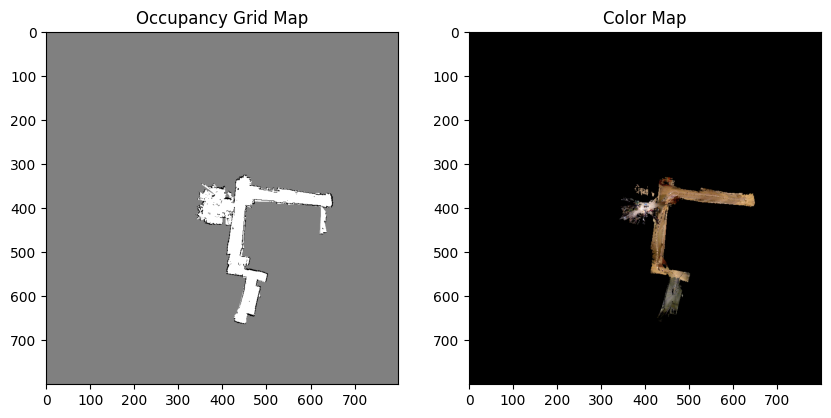

In [20]:
width = 800
resolution = 0.1 
grid_map = np.zeros((width, width), dtype=np.float32)
grid_map_color = np.zeros((width, width, 3), dtype=np.uint8)

# probability of occupied and free
l_occ = np.log(0.7 / 0.3)
l_free = np.log(0.3 / 0.7)

def bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ):
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    n = 1 + dx + dy
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy
    dx *= 2
    dy *= 2

    for _ in range(n):
        if (0 <= x < width) and (0 <= y < width):
            grid_map[y, x] += l_free
        if error > 0:
            x += x_inc
            error -= dy
        else:
            y += y_inc
            error += dx
        if (x == x1) and (y == y1):
            break
    if (0 <= x1 < width) and (0 <= y1 < width):
        grid_map[y1, x1] += l_occ - l_free

print('generating the texture map')
print('about 8 minutes-----------------')

for i in range(1, len(lidar_stamps), 1):
    points = lidar_to_points(lidar_ranges[:,i], lidar_angle_min, lidar_angle_increment)
    pose = result_poses[i]
    points_world = np.dot(pose[:2, :2], points.T).T + pose[:2, 2]
    points_map = (points_world / resolution + width / 2).astype(np.int32)

    x0, y0 = int(pose[0, 2] / resolution + width / 2), int(pose[1, 2] / resolution + width / 2)

    for point in points_map:
        x1, y1 = point
        bresenham_2d(grid_map, x0, y0, x1, y1, l_free, l_occ)

    prob_map = 1 / (1 + np.exp(grid_map))

    # project the rgbd pointcloud to the map
    pcd = aligned_ground_pointcloud[i]
    if pcd is not None:
        points_rgbd = np.asarray(pcd.points)[:,:2]
        colors_rgbd = np.asarray(pcd.colors) * 255
        pose = result_poses[i]
        points_rgbd_world = np.dot(pose[:2, :2], points_rgbd.T).T + pose[:2, 2]
        points_rgbd_map = (points_rgbd_world / resolution + width / 2).astype(np.int32)

        prob_map = 1 / (1 + np.exp(grid_map))

        # if the map coordinates' value is greater than 0.7, then draw the rgbd pointcloud
        mask_occupied = prob_map[points_rgbd_map[:, 1], points_rgbd_map[:, 0]] > 0.7
        grid_map_color[points_rgbd_map[mask_occupied, 1], points_rgbd_map[mask_occupied, 0]] = colors_rgbd[mask_occupied]

    if i % 1000 == 1 and i > 1:
        print(f'processing {i}th frame')

prob_map = 1 / (1 + np.exp(grid_map))
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(prob_map, cmap='gray')
plt.title('Occupancy Grid Map')
plt.subplot(1, 2, 2)
plt.imshow(grid_map_color)
plt.title('Color Map')
plt.show()